In [1]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from torchvision import models

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Device: {device}")
print(f" GPU tersedia: {torch.cuda.device_count()} unit")

DATASET_PATH = Path("/kaggle/input/iwilldoit/dataset_clean")
OUTPUT_DIR = Path("/kaggle/working/swin_results")
os.makedirs(OUTPUT_DIR, exist_ok=True)

 Device: cuda
 GPU tersedia: 2 unit


In [3]:
IMG_SIZE = 384  # Swin-V2 optimal size
BATCH_SIZE = 12  # Small batch for better generalization
EPOCHS = 50
LR_WARMUP = 1e-3  # Stage 1: warmup
LR_FINETUNE = 5e-6  # Stage 2: fine-tune
WEIGHT_DECAY = 1e-3  # Aggressive regularization
NUM_CLASSES = 70
WARMUP_EPOCHS = 5

In [4]:
def preprocess_face(image):
    """
    Advanced preprocessing untuk wajah yang sudah di-crop RetinaFace
    """
    # CLAHE untuk meningkatkan kontras per channel
    if len(image.shape) == 3 and image.shape[2] == 3:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        image[:,:,0] = clahe.apply(image[:,:,0])
        image[:,:,1] = clahe.apply(image[:,:,1])
        image[:,:,2] = clahe.apply(image[:,:,2])
    return image

In [5]:
class FaceDataset(Dataset):
    def __init__(self, paths, labels, transform=None, preprocess=True):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.preprocess = preprocess

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # Load image
        img = plt.imread(self.paths[idx])
        
        # Handle different image formats
        if img.shape[-1] == 4:  # RGBA
            img = img[..., :3]
        elif len(img.shape) == 2:  # Grayscale
            img = np.stack([img] * 3, axis=-1)
        
        # Convert to uint8 if needed
        if img.dtype == np.float32 or img.dtype == np.float64:
            img = (img * 255).astype(np.uint8)
        
        # Apply face preprocessing
        if self.preprocess:
            img = preprocess_face(img)
        
        # Apply augmentation
        if self.transform:
            img = self.transform(image=img)['image']
        
        return img, self.labels[idx]


In [6]:
print("🔍 Memuat dataset...")
all_samples = []
classes = sorted([d.name for d in DATASET_PATH.iterdir() if d.is_dir()])

for class_name in classes:
    class_dir = DATASET_PATH / class_name
    for img_path in class_dir.glob("*"):
        if img_path.suffix.lower() in {'.jpg', '.jpeg', '.png', '.webp'}:
            all_samples.append((str(img_path), classes.index(class_name)))

paths, labels = zip(*all_samples)
labels = list(labels)

print(f"📊 Total dataset: {len(paths)} gambar dari {len(classes)} kelas")

# Analisis distribusi kelas
class_counts = Counter(labels)
min_samples = min(class_counts.values())
max_samples = max(class_counts.values())
print(f"📊 Sampel per kelas: Min={min_samples}, Max={max_samples}, Avg={len(paths)/len(classes):.1f}")

# SMART STRATIFIED SPLIT (handle small dataset)
if len(paths) < len(classes) * 5:
    print("⚠️ Dataset kecil terdeteksi! Menggunakan manual stratified split...")
    
    train_paths, val_paths = [], []
    train_labels, val_labels = [], []
    
    for class_idx in range(len(classes)):
        class_samples = [(p, l) for p, l in zip(paths, labels) if l == class_idx]
        
        if len(class_samples) == 1:
            train_paths.append(class_samples[0][0])
            train_labels.append(class_samples[0][1])
        elif len(class_samples) == 2:
            train_paths.append(class_samples[0][0])
            train_labels.append(class_samples[0][1])
            val_paths.append(class_samples[1][0])
            val_labels.append(class_samples[1][1])
        else:
            n_val = max(1, int(len(class_samples) * 0.2))
            np.random.seed(42)
            np.random.shuffle(class_samples)
            
            for i, (p, l) in enumerate(class_samples):
                if i < n_val:
                    val_paths.append(p)
                    val_labels.append(l)
                else:
                    train_paths.append(p)
                    train_labels.append(l)
else:
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        paths, labels, test_size=0.2, random_state=42, stratify=labels
    )

print(f"📊 Train: {len(train_paths)} | Val: {len(val_paths)}")

🔍 Memuat dataset...
📊 Total dataset: 278 gambar dari 70 kelas
📊 Sampel per kelas: Min=3, Max=4, Avg=4.0
⚠️ Dataset kecil terdeteksi! Menggunakan manual stratified split...
📊 Train: 208 | Val: 70


In [7]:
print("🎨 Setup augmentations...")

train_transform = A.Compose([
    # Geometric
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.7),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.15,
        rotate_limit=10,
        border_mode=cv2.BORDER_CONSTANT,
        p=0.6
    ),
    A.Perspective(scale=(0.05, 0.1), p=0.4),
    
    # Color/Lighting (CRITICAL for faces!)
    A.RandomBrightnessContrast(
        brightness_limit=0.3,
        contrast_limit=0.3,
        p=0.8
    ),
    A.HueSaturationValue(
        hue_shift_limit=15,
        sat_shift_limit=30,
        val_shift_limit=25,
        p=0.7
    ),
    A.RandomGamma(gamma_limit=(70, 130), p=0.5),
    A.RandomShadow(
        shadow_roi=(0, 0.5, 1, 1),
        num_shadows_lower=1,
        num_shadows_upper=2,
        shadow_dimension=5,
        p=0.3
    ),
    
    # Noise & Blur
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 80.0), p=1.0),
        A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=1.0),
        A.MultiplicativeNoise(multiplier=(0.9, 1.1), p=1.0),
    ], p=0.5),
    
    A.OneOf([
        A.MotionBlur(blur_limit=7, p=1.0),
        A.MedianBlur(blur_limit=5, p=1.0),
        A.GaussianBlur(blur_limit=5, p=1.0),
    ], p=0.3),
    
    A.ImageCompression(quality_lower=60, quality_upper=100, p=0.3),
    
    # Occlusion (simulate accessories/obstructions)
    A.CoarseDropout(
        max_holes=8,
        max_height=30,
        max_width=30,
        min_holes=1,
        min_height=10,
        min_width=10,
        fill_value=0,
        p=0.4
    ),
    A.GridDropout(ratio=0.3, p=0.2),
    
    # Elastic deformation
    A.OneOf([
        A.ElasticTransform(
            alpha=1,
            sigma=50,
            alpha_affine=30,
            border_mode=cv2.BORDER_CONSTANT,
            p=1.0
        ),
        A.GridDistortion(
            num_steps=5,
            distort_limit=0.3,
            border_mode=cv2.BORDER_CONSTANT,
            p=1.0
        ),
    ], p=0.3),
    
    # Normalization
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Create datasets
train_dataset = FaceDataset(train_paths, train_labels, train_transform, preprocess=True)
val_dataset = FaceDataset(val_paths, val_labels, val_transform, preprocess=True)


🎨 Setup augmentations...


In [8]:
print("⚖️ Setup weighted sampler untuk kelas imbalanced...")
class_weights = {cls: 1.0 / count for cls, count in Counter(train_labels).items()}
sample_weights = [class_weights[label] for label in train_labels]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


⚖️ Setup weighted sampler untuk kelas imbalanced...


In [9]:
print("🤖 Memuat Swin Transformer V2 Large...")

# Deteksi versi torchvision
import torchvision
tv_version = torchvision.__version__
print(f"📦 Torchvision version: {tv_version}")

try:
    # Cara baru (torchvision >= 0.15)
    from torchvision.models import Swin_V2_B_Weights
    model = models.swin_v2_b(weights=Swin_V2_B_Weights.IMAGENET1K_V1)
    print("✅ Menggunakan Swin_V2_B_Weights (versi baru)")
except (ImportError, AttributeError):
    # Cara lama (torchvision < 0.15)
    print("⚠️ Menggunakan pretrained=True (versi lama)")
    model = models.swin_v2_b(pretrained=True)

print(f"✅ Swin-V2-Base loaded! Feature dim: {model.head.in_features}")

# Custom classification head dengan regularization
model.head = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.head.in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.3),
    nn.Linear(512, NUM_CLASSES)
)

# Multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"🚀 Menggunakan {torch.cuda.device_count()} GPU dengan DataParallel")
    model = nn.DataParallel(model)

model = model.to(device)
print("✅ Model siap!")


🤖 Memuat Swin Transformer V2 Large...
📦 Torchvision version: 0.21.0+cu124


Downloading: "https://download.pytorch.org/models/swin_v2_b-781e5279.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_b-781e5279.pth
100%|██████████| 336M/336M [00:01<00:00, 195MB/s]


✅ Menggunakan Swin_V2_B_Weights (versi baru)
✅ Swin-V2-Base loaded! Feature dim: 1024
🚀 Menggunakan 2 GPU dengan DataParallel
✅ Model siap!


In [10]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Focal Loss + Label Smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
focal_criterion = FocalLoss(alpha=1.0, gamma=2.0)

In [11]:
def mixup_data(x, y, alpha=0.2):
    """Mixup augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [12]:
def train_epoch(model, loader, criterion, optimizer, device, use_mixup=True):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Apply mixup
        if use_mixup and np.random.rand() > 0.5:
            images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=0.2)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        else:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(loader), 100. * correct / total


In [13]:
def validate(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return acc, f1, all_preds, all_labels

In [14]:
print("\n" + "="*60)
print("🔥 STAGE 1: WARMUP (Freeze backbone, train head only)")
print("="*60)

# Freeze backbone
if hasattr(model, 'module'):
    for param in model.module.parameters():
        param.requires_grad = False
    for param in model.module.head.parameters():
        param.requires_grad = True
else:
    for param in model.parameters():
        param.requires_grad = False
    for param in model.head.parameters():
        param.requires_grad = True

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR_WARMUP,
    weight_decay=WEIGHT_DECAY
)

best_f1_warmup = 0.0

for epoch in range(WARMUP_EPOCHS):
    print(f"\n📍 Epoch {epoch+1}/{WARMUP_EPOCHS}")
    
    train_loss, train_acc = train_epoch(
        model, train_loader, focal_criterion, optimizer, device, use_mixup=False
    )
    val_acc, val_f1, _, _ = validate(model, val_loader, device)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Acc: {val_acc*100:.2f}% | Val F1: {val_f1:.4f}")
    
    if val_f1 > best_f1_warmup:
        best_f1_warmup = val_f1
        save_path = OUTPUT_DIR / "warmup_best.pth"
        state_dict = model.module.state_dict() if hasattr(model, 'module') else model.state_dict()
        torch.save(state_dict, save_path)
        print(f"✅ Warmup model saved! (F1: {val_f1:.4f})")



🔥 STAGE 1: WARMUP (Freeze backbone, train head only)

📍 Epoch 1/5


Validating: 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Train Loss: 4.1251 | Train Acc: 5.88%
Val Acc: 7.14% | Val F1: 0.0376
✅ Warmup model saved! (F1: 0.0376)

📍 Epoch 2/5


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Train Loss: 3.7735 | Train Acc: 5.88%
Val Acc: 8.57% | Val F1: 0.0385
✅ Warmup model saved! (F1: 0.0385)

📍 Epoch 3/5


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Train Loss: 3.5608 | Train Acc: 10.29%
Val Acc: 18.57% | Val F1: 0.1104
✅ Warmup model saved! (F1: 0.1104)

📍 Epoch 4/5


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]


Train Loss: 3.2181 | Train Acc: 22.55%
Val Acc: 25.71% | Val F1: 0.1689
✅ Warmup model saved! (F1: 0.1689)

📍 Epoch 5/5


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]


Train Loss: 3.0663 | Train Acc: 20.59%
Val Acc: 30.00% | Val F1: 0.2207
✅ Warmup model saved! (F1: 0.2207)


In [15]:
print("\n" + "="*60)
print("🔥 STAGE 2: FULL FINE-TUNING (All layers trainable)")
print("="*60)

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Discriminative learning rates
if hasattr(model, 'module'):
    backbone_params = [p for n, p in model.module.named_parameters() if 'head' not in n]
    head_params = model.module.head.parameters()
else:
    backbone_params = [p for n, p in model.named_parameters() if 'head' not in n]
    head_params = model.head.parameters()

optimizer = optim.AdamW([
    {'params': backbone_params, 'lr': LR_FINETUNE},
    {'params': head_params, 'lr': LR_FINETUNE * 10}
], weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=2,
    eta_min=1e-7
)

best_f1 = 0.0
patience_counter = 0
patience = 15

for epoch in range(EPOCHS - WARMUP_EPOCHS):
    print(f"\n📍 Epoch {epoch+1}/{EPOCHS - WARMUP_EPOCHS}")
    
    train_loss, train_acc = train_epoch(
        model, train_loader, focal_criterion, optimizer, device, use_mixup=True
    )
    val_acc, val_f1, val_preds, val_labels = validate(model, val_loader, device)
    
    scheduler.step()
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Acc: {val_acc*100:.2f}% | Val F1: {val_f1:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        save_path = OUTPUT_DIR / "swin_best_model.pth"
        state_dict = model.module.state_dict() if hasattr(model, 'module') else model.state_dict()
        torch.save({
            'epoch': epoch,
            'model_state_dict': state_dict,
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
            'val_acc': val_acc,
        }, save_path)
        print(f"✅ Best model saved! (F1: {val_f1:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"⚠️ Early stopping triggered! No improvement for {patience} epochs.")
            break



🔥 STAGE 2: FULL FINE-TUNING (All layers trainable)

📍 Epoch 1/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]


Train Loss: 3.1197 | Train Acc: 19.61%
Val Acc: 30.00% | Val F1: 0.2242
LR: 4.88e-06
✅ Best model saved! (F1: 0.2242)

📍 Epoch 2/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]


Train Loss: 2.9737 | Train Acc: 19.12%
Val Acc: 31.43% | Val F1: 0.2361
LR: 4.53e-06
✅ Best model saved! (F1: 0.2361)

📍 Epoch 3/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Train Loss: 3.3076 | Train Acc: 15.69%
Val Acc: 30.00% | Val F1: 0.2248
LR: 3.99e-06

📍 Epoch 4/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]


Train Loss: 3.0337 | Train Acc: 18.63%
Val Acc: 28.57% | Val F1: 0.2060
LR: 3.31e-06

📍 Epoch 5/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


Train Loss: 2.9595 | Train Acc: 19.61%
Val Acc: 28.57% | Val F1: 0.2155
LR: 2.55e-06

📍 Epoch 6/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]


Train Loss: 2.8766 | Train Acc: 22.55%
Val Acc: 31.43% | Val F1: 0.2353
LR: 1.79e-06

📍 Epoch 7/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]


Train Loss: 3.0766 | Train Acc: 16.67%
Val Acc: 30.00% | Val F1: 0.2239
LR: 1.11e-06

📍 Epoch 8/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


Train Loss: 3.0398 | Train Acc: 15.20%
Val Acc: 31.43% | Val F1: 0.2377
LR: 5.68e-07
✅ Best model saved! (F1: 0.2377)

📍 Epoch 9/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]


Train Loss: 3.0828 | Train Acc: 19.61%
Val Acc: 28.57% | Val F1: 0.2087
LR: 2.20e-07

📍 Epoch 10/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


Train Loss: 3.0343 | Train Acc: 22.06%
Val Acc: 31.43% | Val F1: 0.2309
LR: 5.00e-06

📍 Epoch 11/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]


Train Loss: 2.9479 | Train Acc: 10.78%
Val Acc: 32.86% | Val F1: 0.2545
LR: 4.97e-06
✅ Best model saved! (F1: 0.2545)

📍 Epoch 12/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


Train Loss: 2.8655 | Train Acc: 20.59%
Val Acc: 30.00% | Val F1: 0.2321
LR: 4.88e-06

📍 Epoch 13/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


Train Loss: 3.0797 | Train Acc: 19.12%
Val Acc: 32.86% | Val F1: 0.2499
LR: 4.73e-06

📍 Epoch 14/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s]


Train Loss: 2.8440 | Train Acc: 23.04%
Val Acc: 34.29% | Val F1: 0.2652
LR: 4.53e-06
✅ Best model saved! (F1: 0.2652)

📍 Epoch 15/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


Train Loss: 2.7174 | Train Acc: 25.00%
Val Acc: 34.29% | Val F1: 0.2610
LR: 4.28e-06

📍 Epoch 16/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]


Train Loss: 2.9430 | Train Acc: 19.12%
Val Acc: 34.29% | Val F1: 0.2720
LR: 3.99e-06
✅ Best model saved! (F1: 0.2720)

📍 Epoch 17/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


Train Loss: 2.6418 | Train Acc: 29.41%
Val Acc: 34.29% | Val F1: 0.2664
LR: 3.66e-06

📍 Epoch 18/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]


Train Loss: 2.6767 | Train Acc: 24.51%
Val Acc: 34.29% | Val F1: 0.2624
LR: 3.31e-06

📍 Epoch 19/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


Train Loss: 2.7532 | Train Acc: 25.98%
Val Acc: 37.14% | Val F1: 0.2938
LR: 2.93e-06
✅ Best model saved! (F1: 0.2938)

📍 Epoch 20/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


Train Loss: 2.6980 | Train Acc: 22.55%
Val Acc: 37.14% | Val F1: 0.2912
LR: 2.55e-06

📍 Epoch 21/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


Train Loss: 2.9575 | Train Acc: 26.47%
Val Acc: 35.71% | Val F1: 0.2670
LR: 2.17e-06

📍 Epoch 22/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]


Train Loss: 2.6223 | Train Acc: 24.02%
Val Acc: 37.14% | Val F1: 0.2896
LR: 1.79e-06

📍 Epoch 23/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


Train Loss: 2.6641 | Train Acc: 26.96%
Val Acc: 37.14% | Val F1: 0.2862
LR: 1.44e-06

📍 Epoch 24/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]


Train Loss: 2.4418 | Train Acc: 26.96%
Val Acc: 40.00% | Val F1: 0.3169
LR: 1.11e-06
✅ Best model saved! (F1: 0.3169)

📍 Epoch 25/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]


Train Loss: 2.5447 | Train Acc: 28.43%
Val Acc: 41.43% | Val F1: 0.3298
LR: 8.18e-07
✅ Best model saved! (F1: 0.3298)

📍 Epoch 26/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]


Train Loss: 2.5182 | Train Acc: 31.86%
Val Acc: 41.43% | Val F1: 0.3298
LR: 5.68e-07

📍 Epoch 27/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]


Train Loss: 2.6159 | Train Acc: 25.49%
Val Acc: 38.57% | Val F1: 0.3095
LR: 3.67e-07

📍 Epoch 28/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


Train Loss: 2.6429 | Train Acc: 23.53%
Val Acc: 40.00% | Val F1: 0.3117
LR: 2.20e-07

📍 Epoch 29/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


Train Loss: 2.7163 | Train Acc: 21.08%
Val Acc: 37.14% | Val F1: 0.2943
LR: 1.30e-07

📍 Epoch 30/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]


Train Loss: 2.6899 | Train Acc: 26.96%
Val Acc: 40.00% | Val F1: 0.3105
LR: 5.00e-06

📍 Epoch 31/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


Train Loss: 2.6905 | Train Acc: 25.49%
Val Acc: 42.86% | Val F1: 0.3388
LR: 4.99e-06
✅ Best model saved! (F1: 0.3388)

📍 Epoch 32/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]


Train Loss: 2.6010 | Train Acc: 25.49%
Val Acc: 45.71% | Val F1: 0.3664
LR: 4.97e-06
✅ Best model saved! (F1: 0.3664)

📍 Epoch 33/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]


Train Loss: 2.5482 | Train Acc: 27.45%
Val Acc: 42.86% | Val F1: 0.3436
LR: 4.93e-06

📍 Epoch 34/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]


Train Loss: 2.4435 | Train Acc: 28.43%
Val Acc: 44.29% | Val F1: 0.3560
LR: 4.88e-06

📍 Epoch 35/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]


Train Loss: 2.5010 | Train Acc: 24.02%
Val Acc: 41.43% | Val F1: 0.3219
LR: 4.81e-06

📍 Epoch 36/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


Train Loss: 2.3782 | Train Acc: 29.41%
Val Acc: 45.71% | Val F1: 0.3788
LR: 4.73e-06
✅ Best model saved! (F1: 0.3788)

📍 Epoch 37/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]


Train Loss: 2.5263 | Train Acc: 32.35%
Val Acc: 47.14% | Val F1: 0.4010
LR: 4.64e-06
✅ Best model saved! (F1: 0.4010)

📍 Epoch 38/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]


Train Loss: 2.4454 | Train Acc: 30.39%
Val Acc: 51.43% | Val F1: 0.4319
LR: 4.53e-06
✅ Best model saved! (F1: 0.4319)

📍 Epoch 39/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]


Train Loss: 2.6429 | Train Acc: 23.04%
Val Acc: 51.43% | Val F1: 0.4352
LR: 4.41e-06
✅ Best model saved! (F1: 0.4352)

📍 Epoch 40/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


Train Loss: 2.2691 | Train Acc: 31.37%
Val Acc: 50.00% | Val F1: 0.4186
LR: 4.28e-06

📍 Epoch 41/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


Train Loss: 2.2399 | Train Acc: 37.25%
Val Acc: 50.00% | Val F1: 0.4162
LR: 4.14e-06

📍 Epoch 42/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


Train Loss: 2.6301 | Train Acc: 18.63%
Val Acc: 48.57% | Val F1: 0.3971
LR: 3.99e-06

📍 Epoch 43/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.60it/s]


Train Loss: 2.4185 | Train Acc: 34.80%
Val Acc: 50.00% | Val F1: 0.4167
LR: 3.83e-06

📍 Epoch 44/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]


Train Loss: 2.2792 | Train Acc: 33.33%
Val Acc: 50.00% | Val F1: 0.4190
LR: 3.66e-06

📍 Epoch 45/45


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

Train Loss: 2.1451 | Train Acc: 23.53%
Val Acc: 48.57% | Val F1: 0.3995
LR: 3.49e-06


In [16]:
print("\n" + "="*60)
print("🎯 EVALUASI FINAL dengan Best Model")
print("="*60)

# Load best model (Fix PyTorch 2.6 weights_only issue)
try:
    checkpoint = torch.load(OUTPUT_DIR / "swin_best_model.pth", map_location=device, weights_only=False)
except TypeError:
    # For older PyTorch versions that don't have weights_only parameter
    checkpoint = torch.load(OUTPUT_DIR / "swin_best_model.pth", map_location=device)

if hasattr(model, 'module'):
    model.module.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint['model_state_dict'])

# Final validation
final_acc, final_f1, final_preds, final_labels = validate(model, val_loader, device)

print("\n" + "="*60)
print("📊 HASIL AKHIR - SWIN TRANSFORMER V2")
print("="*60)
print(f"Accuracy: {final_acc*100:.2f}%")
print(f"F1-Score (macro): {final_f1:.4f}")
print("="*60)


🎯 EVALUASI FINAL dengan Best Model


Validating: 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]


📊 HASIL AKHIR - SWIN TRANSFORMER V2
Accuracy: 51.43%
F1-Score (macro): 0.4352



📊 Generating confusion matrix...
✅ Confusion matrix saved to /kaggle/working/swin_results/swin_confusion_matrix.png


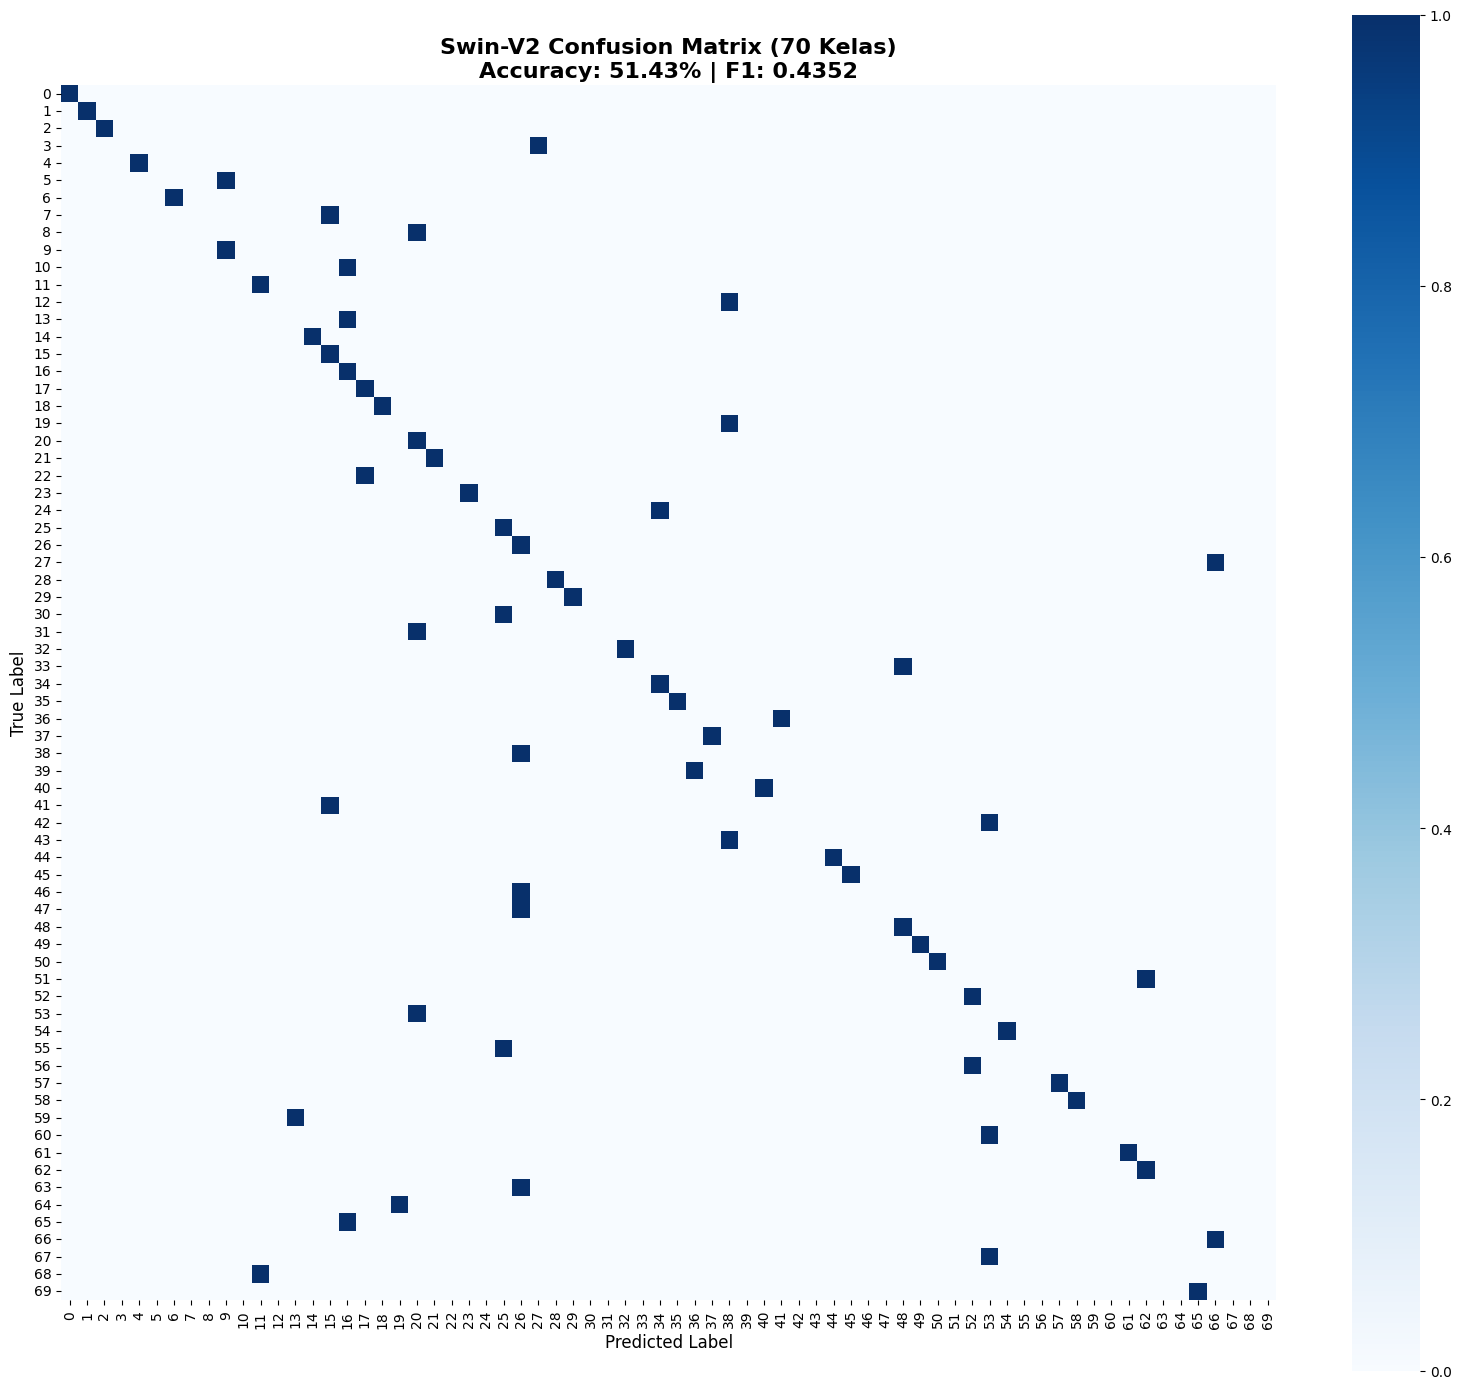

In [17]:
print("\n📊 Generating confusion matrix...")
cm = confusion_matrix(final_labels, final_preds)

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=False, cmap="Blues", cbar=True, square=True)
plt.title(f"Swin-V2 Confusion Matrix (70 Kelas)\nAccuracy: {final_acc*100:.2f}% | F1: {final_f1:.4f}", 
          fontsize=16, fontweight='bold')
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "swin_confusion_matrix.png", dpi=200, bbox_inches='tight')
print(f"✅ Confusion matrix saved to {OUTPUT_DIR / 'swin_confusion_matrix.png'}")


In [18]:
print("\n📄 Generating classification report...")
report = classification_report(
    final_labels, 
    final_preds, 
    target_names=classes, 
    output_dict=True,
    zero_division=0
)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(OUTPUT_DIR / "swin_classification_report.csv")
print(f"✅ Classification report saved to {OUTPUT_DIR / 'swin_classification_report.csv'}")

# Print per-class metrics for worst performing classes
print("\n🔍 Top 5 Worst Performing Classes:")
class_f1 = {classes[i]: report[classes[i]]['f1-score'] 
            for i in range(len(classes)) if classes[i] in report}
worst_classes = sorted(class_f1.items(), key=lambda x: x[1])[:5]
for class_name, f1_score in worst_classes:
    print(f"  {class_name}: F1={f1_score:.3f}")

print("\n✅ Swin-V2 Training Complete!")
print(f"📁 All results saved in: {OUTPUT_DIR}")
print(f"🏆 Best Model: {OUTPUT_DIR / 'swin_best_model.pth'}")
print(f"📊 Best F1-Score: {best_f1:.4f}")


📄 Generating classification report...
✅ Classification report saved to /kaggle/working/swin_results/swin_classification_report.csv

🔍 Top 5 Worst Performing Classes:
  Aldi Sanjaya: F1=0.000
  Alief Fathur Rahman: F1=0.000
  Bayu Ega Ferdana: F1=0.000
  Bayu Prameswara Haris: F1=0.000
  Bintang Fikri Fauzan: F1=0.000

✅ Swin-V2 Training Complete!
📁 All results saved in: /kaggle/working/swin_results
🏆 Best Model: /kaggle/working/swin_results/swin_best_model.pth
📊 Best F1-Score: 0.4352
